# Convolutional blocks with Bag of Words
In this notebook we kept it simple by using some normal convolutional blocks and Bag of Words for the question processing part.

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import os
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

#### Main parameters

In [4]:
img_h = 400
img_w = 700
num_answers = 58

#### Data preparation

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [6]:
import json
import os

train_json_directory = '/kaggle/input/vqa-dataset/VQA_Dataset/train_questions_annotations.json' #directory of the train_questions file
test_json_directory = '/kaggle/input/vqa-dataset/VQA_Dataset/test_questions.json' #directory of the test_questions

classes = { 
            '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'apple': 6,
            'baseball': 7, 'bench': 8, 'bike': 9, 'bird': 10, 'black': 11, 'blanket': 12, 'blue': 13,
            'bone': 14, 'book': 15, 'boy': 16, 'brown': 17, 'cat': 18, 'chair': 19, 'couch': 20,
            'dog': 21, 'floor': 22, 'food': 23, 'football': 24, 'girl': 25, 'grass': 26, 'gray': 27,
            'green': 28, 'left': 29, 'log': 30, 'man': 31, 'monkey bars': 32, 'no': 33, 'nothing': 34,
            'orange': 35, 'pie': 36, 'plant': 37, 'playing': 38, 'red': 39, 'right': 40, 'rug': 41,
            'sandbox': 42, 'sitting': 43, 'sleeping': 44, 'soccer': 45, 'squirrel': 46, 'standing': 47, 
            'stool': 48, 'sunny': 49, 'table': 50, 'tree': 51, 'watermelon': 52, 'white': 53, 'wine': 54, 
            'woman': 55, 'yellow': 56, 'yes': 57 
              }


#Unpacking of the train_file
train = {}
train = json.load(open(train_json_directory))

train_questions, train_answers, train_image_ids = [], [], []

for line in train.items():

    train_questions.append(line[1]["question"])
    train_answers.append(line[1]["answer"])
    train_image_ids.append(line[1]["image_id"])


#Unpacking of the test_file

test = json.load(open(test_json_directory))

test_questions, test_image_ids = [], []

for line in test.items():
    
    test_question_ids = list(test.keys())
    test_questions.append(line[1]["question"])
    test_image_ids.append(line[1]["image_id"])

print('Training questions: ')
print(len(train_questions))
print('Testing questions: ')
print(len(test_questions))  

Training questions: 
58832
Testing questions: 
6372


### TRAINING AND TESTING IMAGES
First of all we have to extract the training images from the main folder, resizing them with 'nearest' metric

In [7]:
from PIL import Image

images_folder_directory = '/kaggle/input/vqa-dataset/VQA_Dataset/Training'

resize_shape=[32,32]

def load_and_proccess_image(image_path):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
    img = Image.open(image_path)
    img = img.resize(resize_shape, resample=Image.NEAREST)
    im = img_to_array(img)
    
    return im / 255 - 0.5

def read_images(paths):
    # paths is a dict mapping image ID to image path
    # Returns a dict mapping image ID to the processed image
    ims = {}
    for image_id, image_path in paths.items():
        ims[image_id] = load_and_proccess_image(image_path)

    return ims

def extract_paths():
    paths = {}
    for filename in os.listdir(images_folder_directory):
        if filename.endswith('.png'):
            img_id = filename[:-4]
            paths[img_id] = os.path.join(images_folder_directory, filename)
                
    return paths

In [8]:
train_images = read_images(extract_paths())

### TOKENIZATION
Converts words to integers (BOW)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_questions) #Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(test_questions) 

# We add one because the Keras Tokenizer reserves index 0 and never uses it.
vocab_size = len(tokenizer.word_index)+1
print(f'Vocab Size: {vocab_size}')
print(tokenizer.word_index)

#Converting questions to bags of words (BOW)
train_X_seqs = tokenizer.texts_to_matrix(train_questions)
train_Y_seqs = tokenizer.texts_to_matrix(test_questions)
print(f'Example question bag of words: {train_X_seqs[0]}')

#Creating model input images
train_X_ims = np.array([train_images[id] for id in train_image_ids])
test_X_ims = np.array([train_images[id] for id in test_image_ids])

#Creating model outputs
train_answer_indices = [classes[a] for a in train_answers]
train_Y = to_categorical(train_answer_indices)
print(f'Example model output: {train_Y[0]}')

Vocab Size: 4641
{'the': 1, 'is': 2, 'are': 3, 'what': 4, 'how': 5, 'many': 6, 'on': 7, 'in': 8, 'color': 9, 'there': 10, 'a': 11, 'to': 12, 'man': 13, 'of': 14, 'dog': 15, 'woman': 16, 'girl': 17, 'does': 18, 'boy': 19, 'sitting': 20, 'this': 21, 'cat': 22, 'people': 23, 'where': 24, 'they': 25, 'have': 26, 'with': 27, 'picture': 28, 'it': 29, 'couch': 30, 'do': 31, 'playing': 32, 'table': 33, 'lady': 34, 'doing': 35, 'room': 36, 'tree': 37, 'rug': 38, 'baby': 39, 'she': 40, 'at': 41, 'will': 42, 'her': 43, 'same': 44, 'trees': 45, 'for': 46, 'see': 47, 'holding': 48, 'who': 49, 'old': 50, 'windows': 51, 'any': 52, 'shirt': 53, 'pond': 54, 'little': 55, 'ball': 56, 'fire': 57, 'animal': 58, 'sun': 59, 'you': 60, 'animals': 61, 'chair': 62, 'tv': 63, 'that': 64, 'going': 65, 'curtains': 66, 'clouds': 67, 'wall': 68, 'he': 69, 'happy': 70, 'his': 71, 'sky': 72, 'and': 73, 'can': 74, 'be': 75, 'fireplace': 76, 'having': 77, 'sleeping': 78, 'two': 79, 'slide': 80, 'floor': 81, 'did': 82, 

Example question bag of words: [0. 0. 0. ... 0. 0. 0.]
Example model output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Multiply
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.recurrent import LSTM
from keras.layers import merge
from keras.layers.merge import Concatenate

def build_model(im_shape, vocab_size, num_answers):
 
    # The CNN
    im_input = Input(shape=im_shape)

    x1 = Conv2D(8, 3, padding='same')(im_input)
    x1 = MaxPooling2D()(x1)
    x1 = Conv2D(16, 3, padding='same')(x1)
    x1 = MaxPooling2D()(x1)
    x1 = Flatten()(x1)
    x1 = Dense(32, activation='tanh')(x1)

    # The question network
    q_input = Input(shape=(vocab_size,))
    x2 = Dense(32, activation='tanh')(q_input)
    x2 = Dense(32, activation='tanh')(x2)

    # Merge -> output
    out = Multiply()([x1, x2])
    out = Dense(32, activation='tanh')(out)
    out = Dense(num_answers, activation='softmax')(out)

    model = Model(inputs=[im_input, q_input], outputs=out)

    return model

In [29]:
model = build_model((32,32,4), vocab_size, num_answers)

model.compile(Adam(lr=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    296         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   1168        max_pooling2d[0][0]              
____________________________________________________________________________________________

### TRAINING
We chosed Early Stopping with patience 10

In [30]:
callbacks = []

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

model.fit(
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_split=0.2,
  epochs=50,
  callbacks=callbacks,
)

Epoch 1/50
1471/1471 [==============================] - 10s 5ms/step - loss: 2.2407 - accuracy: 0.3901 - val_loss: 1.3727 - val_accuracy: 0.5171
Epoch 2/50
1471/1471 [==============================] - 6s 4ms/step - loss: 1.3075 - accuracy: 0.5375 - val_loss: 1.2181 - val_accuracy: 0.5504
Epoch 3/50
1471/1471 [==============================] - 7s 5ms/step - loss: 1.1615 - accuracy: 0.5753 - val_loss: 1.1469 - val_accuracy: 0.5724
Epoch 4/50
1471/1471 [==============================] - 6s 4ms/step - loss: 1.0614 - accuracy: 0.6027 - val_loss: 1.1067 - val_accuracy: 0.5826
Epoch 5/50
1471/1471 [==============================] - 7s 5ms/step - loss: 1.0114 - accuracy: 0.6193 - val_loss: 1.0860 - val_accuracy: 0.5865
Epoch 6/50
1471/1471 [==============================] - 7s 4ms/step - loss: 0.9694 - accuracy: 0.6348 - val_loss: 1.0681 - val_accuracy: 0.5982
Epoch 7/50
1471/1471 [==============================] - 7s 4ms/step - loss: 0.9333 - accuracy: 0.6466 - val_loss: 1.0669 - val_accuracy

### CSV creation

In [31]:
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'
    with open(os.path.join(results_dir, csv_fname), 'w') as f:
        f.write('Id,Category\n')
        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

#### PREDICTIONs

In [32]:
predictions = model.predict([test_X_ims,train_Y_seqs])

#### Take a random prediction and show his activations

<Figure size 1440x576 with 0 Axes>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

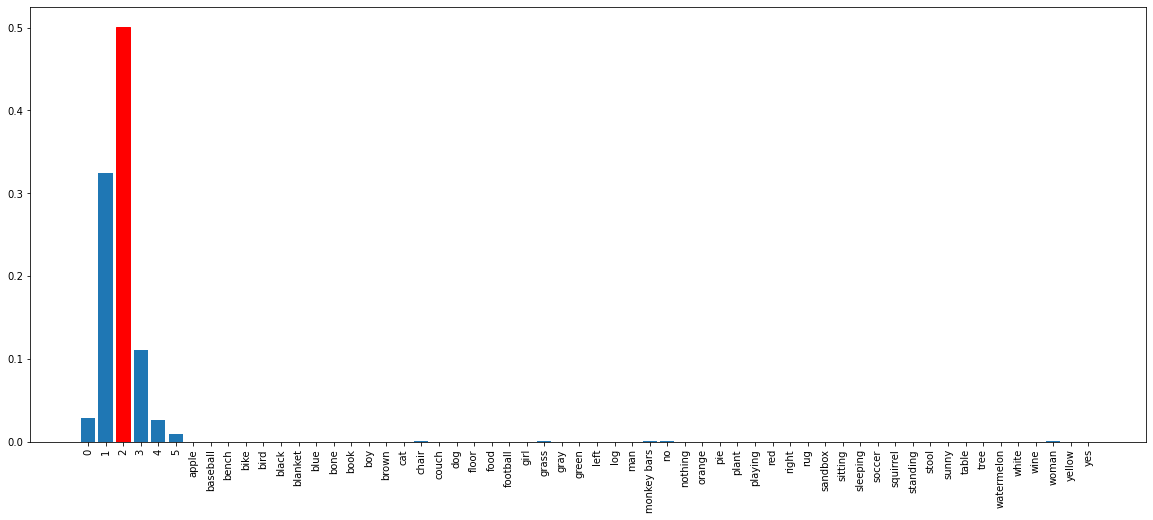

In [36]:
import random
import numpy as np
import matplotlib.pyplot as plt

n = random.randint(1,1000)

labels = []
for key,value in classes.items():
    labels.append(key)

height = predictions[n]
max = np.argmax(height)
plt.figure(figsize=(20,8))
bars = plt.bar(labels, height)
bars[max].set_color('r')
plt.xticks(rotation=90)
plt.show()

#### argmax from predictions

In [34]:
results = {}

for i in range(0,len(predictions)):
   
    current_prediction = predictions[i]
    predict = np.argmax(current_prediction)
    results[test_question_ids[i]] = str(predict)
    i += 1

In [35]:
create_csv(results)